# Pokemon GO Visualizations based on London spawn data

Let's have first look at the data dump from the crawler that was populating a database. 

Generation
-----------

Using [PokéVision.com](https://pokevision.com/) I was able to query pokemon spawns by lat/long values. 
For this notebook I'm restricting the data to what I collected from London UK, sampling from a grid by a constant stride every 5 minutes.

I ignored the four most common pokemon up-front while crawling which were: 

```
16, // pidgey
19, // rattata
21, // spearow
41, // zubat
96 // drowzee
```

Format
------

The data format is really simple, the API returns a unique identifier and an expiration time, which tells when a pokemon despawns- this will act as our "key" to deduplicate and clean data first. 
The real juicy content is in the unique identifier of the pokemon ("pokemon_id") and its lat/long location value. 

In [2]:
import pandas as pd
df = pd.read_csv('data/data.csv', encoding="utf-8-sig")
df.head()

,id,expiration_time,pokemon_id,lat,long
0,1437290,1469531977,86,51.585117,0.079396
1,3258228,1469531978,86,51.585117,0.079396
2,3258226,1469532675,18,51.585281,0.079672
3,2403432,1469532300,7,51.576583,-0.396503
4,2387733,1469532339,13,51.575416,-0.350026


In [3]:
original_count = df['id'].count()
print('%d rows' % original_count)

282921 rows


## Cleaning the data

First off we are going to deduplicate the data, since the crawler might return some duplicated rows on failure conditions. The ID and expiration time come in very handy here and can be used as a safe unique identifier.

Afterwards we are turning the expiration time into a python datetime and add the pokemons' real name.

In [4]:
df = df.drop_duplicates(['id', 'expiration_time'])

# let's see how much we have removed
count = df['id'].count()
print('removed %d rows' % (original_count - count))
print('remaining %d rows' % count)

from datetime import datetime as dt
df['expiration_time'] = df['expiration_time'].apply(lambda x: dt.utcfromtimestamp(x))

removed 41420 rows
remaining 241501 rows


In [5]:
# join with the list of pokemons
pkmn = pd.read_csv('data/pokemon.csv', encoding="utf-8")
df = pd.merge(df, pkmn, on='pokemon_id', how='inner')
df.head()

,id,expiration_time,pokemon_id,lat,long,Name
0,1437290,2016-07-26 11:19:37,86,51.585117,0.079396,Seel
1,3258228,2016-07-26 11:19:38,86,51.585117,0.079396,Seel
2,1666641,2016-07-26 11:21:21,86,51.562280,-0.051938,Seel
3,1572259,2016-07-26 11:21:22,86,51.562280,-0.051938,Seel
4,2957601,2016-07-26 11:20:49,86,51.536197,-0.103055,Seel


## Top 10 most common Pokemon in London

In [6]:
hist = df.groupby('Name')['id'].count().sort_values(ascending=False)
hist[0:10]

Name
Magikarp    19587
Krabby      14467
Weedle      13947
Gastly      13575
Goldeen     12415
Jynx        11111
Psyduck      9843
Poliwag      9656
Staryu       9416
Caterpie     9044
Name: id, dtype: int64

London full of Magikarps!
It seems that London is filled with water type pokemon, 6 out of the 10! 
We will later on figure out if the rumoured affinitization of water and water type pokemon holds.

## Top 10 least common Pokemon in London

In [7]:
hist.tail(10)

Name
Jolteon      3
Chansey      3
Raichu       3
Kabutops     3
Rapidash     3
Machamp      2
Arbok        2
Dugtrio      2
Sandslash    1
Alakazam     1
Name: id, dtype: int64

Not so surprising that the final evolutions are amongst the most uncommon pokemon. 

## Pokemon not found in London

In [8]:
allPokemonNames = set(pkmn['Name'])
# ignore the pokemon we ignored upfront
filteredPokemonNames = allPokemonNames - set(['Pidgey', 'Rattata', 'Spearow', 'Zubat', 'Drowzee'])
# ignore the legendaries
filteredPokemonNames = filteredPokemonNames - set(['Mew', 'Mewtwo', 'Moltres', 'Zapdos', 'Articuno'])
actualPokemonNames = set(df['Name'].unique())

filteredPokemonNames.difference(actualPokemonNames)


{'Charizard',
 'Charmeleon',
 'Ditto',
 'Dodrio',
 'Exeggutor',
 "Farfetch'd",
 'Flareon',
 'Kangaskhan',
 'Tauros'}

I originally expected for only the region locked pokemons (Farfetch'd, Tauros, Kangaskhan) and Ditto to show up here. However, there are some evolutions in there that seem to have a very small chance of spawning and weren't covered by the data yet as I've personally seen Golem and Machamp already. Let's see how it will change over time with more data available. 

## Plotting locations

In [9]:
import geoplotlib as g
from geoplotlib.utils import BoundingBox, DataAccessObject

def savePlotOnLondonMap(data, fileName):
    # define london
    LDN = BoundingBox(north=51.547, west=-0.239, south=51.451011, east=0.072161)
    # massage the data into a format that geoplotlib understands
    geodf = data[['lat', 'long']].copy()
    geodf.rename(columns={'lat': 'lat', 'long': 'lon'}, inplace=True)
    
    g.tiles_provider('positron')
    g.kde(DataAccessObject.from_dataframe(geodf), bw=1)
    g.set_bbox(LDN)
    g.savefig(fileName)
    # inline unfortunately doesn't work :/
    # g.inline()

# plot everything
savePlotOnLondonMap(df, 'img/alllocations')

# give me all charmander locations
geodf = df[df['pokemon_id'] == 4] 
savePlotOnLondonMap(geodf, 'img/charmanderlocations')

# give me all Blastoise locations
geodf = df[df['pokemon_id'] == 9] 
savePlotOnLondonMap(geodf, 'img/blastoiselocations')

('smallest non-zero count', 0.037444165055830925)
('max count:', 80.65928533513852)
('smallest non-zero count', 1.7910636084771928e-08)
('max count:', 5.4195501186478694)
('smallest non-zero count', 3.5821272169543856e-08)
('max count:', 0.31831178348375949)


Let's look at the output:

![title](img/alllocations.png)

Very busy map, you find that the most pokemons are sighted where a lot of people seem to be. Especially parks and touristy areas like Westminster/Greenwich/Hyde Park/The O2. Keep in mind that there is a selection bias, the PokeVision API caches the results heavily and only refreshes on a user request. We won't have any data in parts of London where nobody is using their service.

Let's look at the Charmander spawns:

![title](img/charmanderlocations.png)

There seems to be a so called "nest" in Holland Park and in the Stratford Olympic Park, where there seem to be an unusually high density of Charmanders.

Let's look at much more rarer Blastoise spawns:

![title](img/blastoiselocations.png)

Random places, no real cluster pattern here! I missed two chances already of catching it- I guess I have to grind and evolve one :/

## Automatically finding nests of pokemon

To find nests, we are going to use a simple density based clustering algorithm called DBSCAN for every pokemon where we have more than twenty data points available. Then we simply print out the mean of the point in one cluster and plot it on the map.

In [10]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

for x in df['pokemon_id'].sort_values().unique():   
    dff = df[df['pokemon_id'] == x]   
    cnt = dff['id'].count()
    if cnt > 20:
       dff = dff[['lat', 'long']].copy()
       db = DBSCAN(eps=0.001, min_samples=15, metric='haversine', algorithm='ball_tree').fit(dff.as_matrix())
       pkname = pkmn[pkmn['pokemon_id'] == x].iloc[0]['Name']
       labels = db.labels_
       core_samples_mask = np.zeros_like(labels, dtype=bool)
       core_samples_mask[db.core_sample_indices_] = True
       unique_labels = set(labels)
        
       n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
       if(n_clusters > 1):
           print('found clusters for %s, number of pokemon %d' % (pkname, cnt))
           print('number of clusters: %d' % n_clusters)
           tp = pd.DataFrame(columns=['lat','long'])
           for k in unique_labels:
              # ignore class noise when printing            
              if k != -1:           
                 class_member_mask = (labels == k)
                 output = dff[class_member_mask & core_samples_mask]
                 tp = tp.append(output)
                 center = output.mean()
                 kcount = output['lat'].count()
                 # limit the verbosity of the output
                 if len(unique_labels) < 5:
                    print('found cluster \'%d\' at %f/%f with %d occurrences' % (k, center['lat'], center['long'], kcount))    
           # plot all the clusters in a single map
           savePlotOnLondonMap(tp, 'img/{}_nests'.format(pkname))
           print()
    

found clusters for Bulbasaur, number of pokemon 843
number of clusters: 15
('smallest non-zero count', 8.955318042385964e-08)
('max count:', 4.9676971180041551)

found clusters for Charmander, number of pokemon 1687
number of clusters: 14
('smallest non-zero count', 8.955318042385964e-08)
('max count:', 5.4195501186478694)

found clusters for Squirtle, number of pokemon 4915
number of clusters: 21
('smallest non-zero count', 5.3731908254315777e-08)
('max count:', 3.3422737265794744)

found clusters for Caterpie, number of pokemon 9044
number of clusters: 75
('smallest non-zero count', 1.7910636084771928e-08)
('max count:', 4.4309115900820135)

found clusters for Weedle, number of pokemon 13947
number of clusters: 160
('smallest non-zero count', 1.7910636084771928e-08)
('max count:', 3.8051873517032431)

found clusters for Pidgeotto, number of pokemon 6382
number of clusters: 31
('smallest non-zero count', 3.5821272169543856e-08)
('max count:', 1.3124400673988907)

found clusters for Ra

## Plotting nest locations 

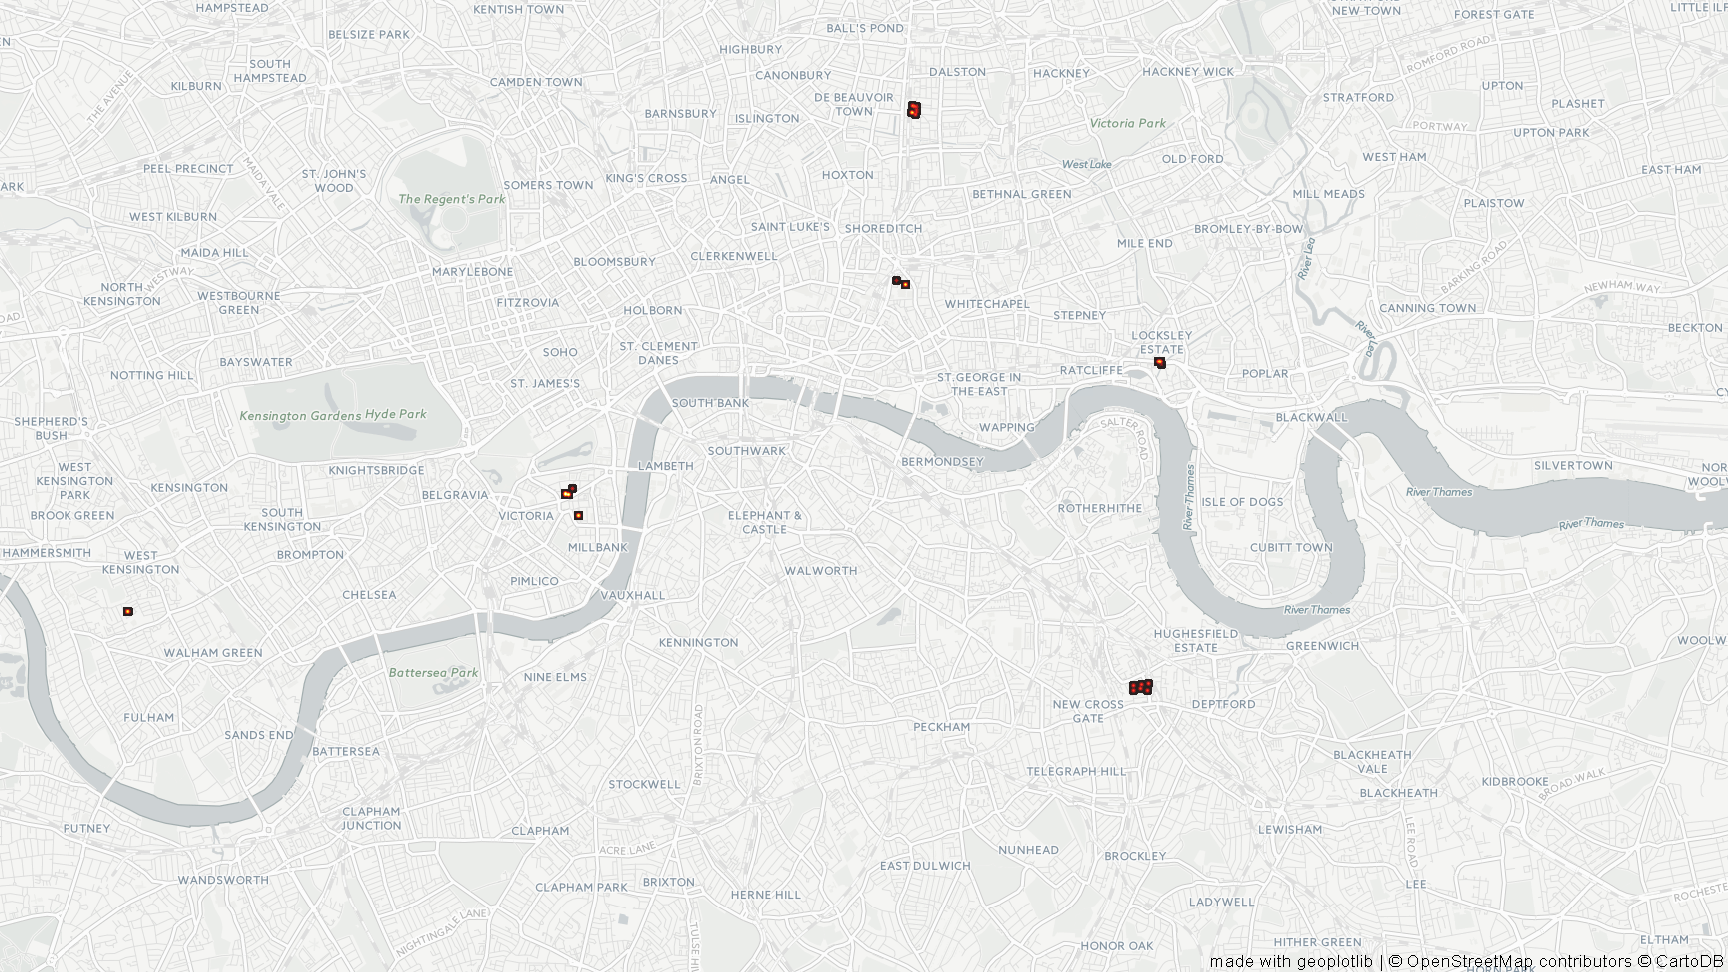

In [13]:
%matplotlib inline
%pylab inline
figsize(25, 12)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from ipywidgets import Dropdown
from glob import glob
from IPython.display import Image, display, HTML, clear_output

imagePaths = glob('img/*_nests.png')

w = Dropdown(
    options=imagePaths,
    value=imagePaths[0]
)

def handleOnChange(value):      
    displayImage(value['new'])
    
def displayImage(fileName):
    clear_output()
    display(HTML('<a href=\'%s\' target="_blank">Open "%s" in a new tab</a>' % (fileName, fileName)))
    display(Image(filename=fileName))

w.observe(handleOnChange, names='value')

display(w)
displayImage(imagePaths[0])

## Analysing spawn timings

Let's see if we find any pattern in the times different pokemon spawn. Note that we only have the expiration time, but we know for most of the pokemon the despawn timer should be 15 minutes. 

## Histogram by spawn minute

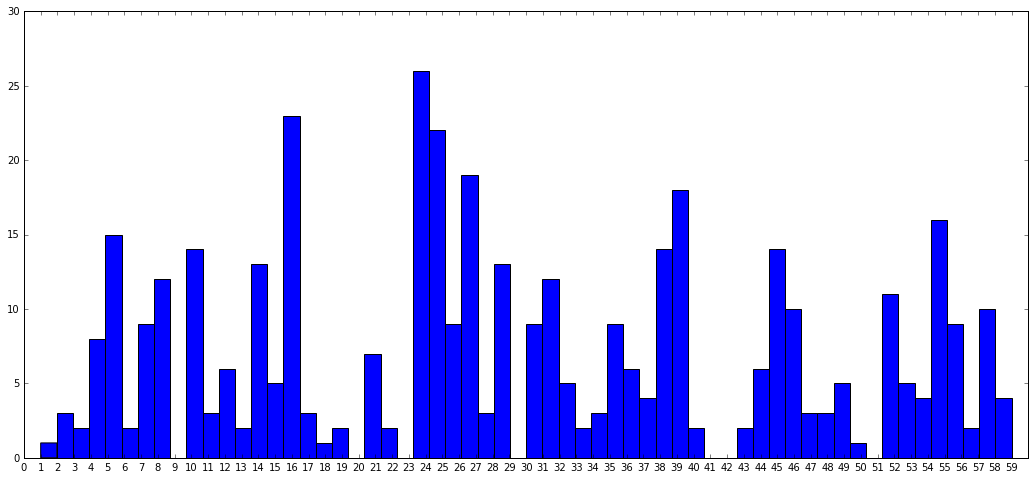

## Histogram by spawn hour

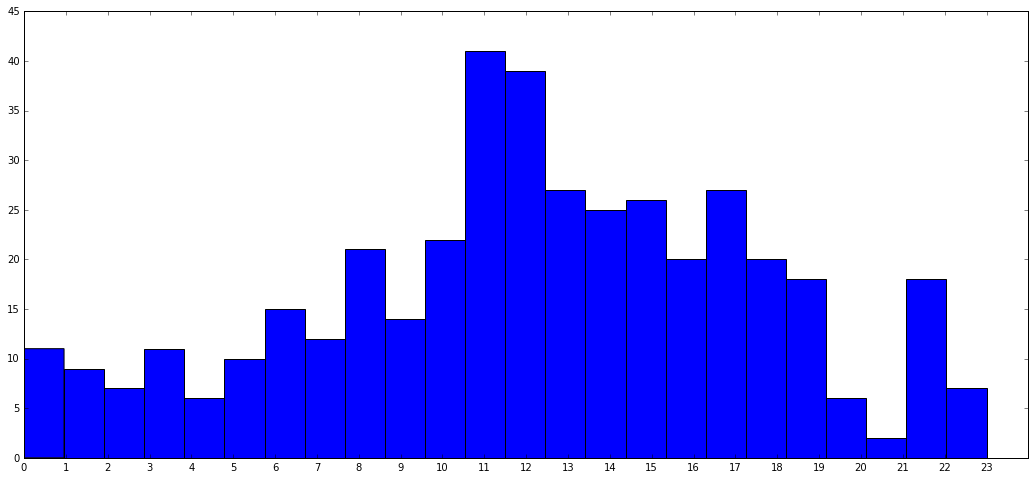

In [14]:
%matplotlib inline
%pylab inline
figsize(18, 8)

from IPython.display import Markdown
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

def minuteChart(occurance_list):
    hour_list = [t.minute for t in occurance_list]
    numbers=[x for x in range(0, 60)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,60)
    plt.hist(hour_list, bins=60)
    plt.show()

def hourChart(occurance_list):
    hour_list = [t.hour for t in occurance_list]
    numbers=[x for x in range(0,24)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,24)
    plt.hist(hour_list, bins=24)
    plt.show()    

delta = datetime.timedelta(minutes=15)
allString = 'All'

wNameList = [allString] + sorted(list(actualPokemonNames))
w = Dropdown(
    options=wNameList,
    value=allString
)

def handleOnChange(value):      
    displayHistograms(value['new'])
    
def displayHistograms(pkName):
    clear_output()
    
    ddf = df
    if pkName != allString:
        ddf = df[df['Name'] == pkName]
        
    # rebase to the spawn delta
    deltadf = ddf['expiration_time'].apply(lambda x: (x - delta))
    display(Markdown('## Histogram by spawn minute'))
    minuteChart(deltadf)
    display(Markdown('## Histogram by spawn hour'))
    hourChart(deltadf)

w.observe(handleOnChange, names='value')

display(w)
displayHistograms(allString)


Minutely, there is a sawtooth pattern in spawns. It seems like their spawn process runs on a cron every 10 minutes. 

Across the whole day, I couldn't gather enough data for it yet and there are gaps from availability issues from the API- will be completed over the next few days.